In [1]:
import pandas as pd
import os

data = pd.read_csv(os.getcwd()+'/data/BNP_data/train.csv')

# Fill NA values accordingly
from sklearn.base import TransformerMixin
import numpy as np

class DataFrameImputer(TransformerMixin):
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
data = DataFrameImputer().fit_transform(data)

# Convert string values to numeric
from sklearn import preprocessing

criteria = data.dtypes == object
object_columns = data[criteria.index[criteria]].columns

le = preprocessing.LabelEncoder()
for col in object_columns:
    data[col] = le.fit_transform(data[col])

# Cross-validation
from sklearn import cross_validation
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(data.drop('target', axis=1), data['target'], \
    test_size=0.33, random_state=5)

In [47]:
# Create a feature map
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()
    
create_feature_map(list(X_train.columns[2:]))

import xgboost as xgb
import operator

xgb_params = {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 6, 'seed': 42, 'eval_metric': 'logloss'}
num_rounds = 1000

dtrain = xgb.DMatrix(X_train, label = Y_train)
gbdt = xgb.train(xgb_params, dtrain, num_rounds)

importance = gbdt.get_fscore(fmap = 'xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] / df['fscore'].sum()

# Grab the most important features
imp_features = df[df['fscore'] > 0.005]['feature']

# Rewrite the feature map
create_feature_map(list(imp_features))

In [31]:
create_feature_map(list(imp_features))

X_train_imp, X_test_imp, Y_train_imp, Y_test_imp = cross_validation.train_test_split(data[imp_features], \
    data['target'], test_size=0.33, random_state=5)

xgb_params = {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 6, 'seed': 42, 'eval_metric': 'logloss'}
num_rounds = 10

# Format the matrices for xgb
dtrain_imp = xgb.DMatrix(X_train_imp, label = Y_train_imp)
dtest_imp = xgb.DMatrix(X_test_imp, label = Y_test_imp)
gbdt_imp = xgb.train(xgb_params, dtrain_imp, num_rounds)

# Get the predicted values for the test data
Y_test_pred_imp = gbdt_imp.predict(dtest_imp)
Y_test_pred_imp[Y_test_pred_imp > 1] = 1
Y_test_pred_imp[Y_test_pred_imp < 0] = 0

# ... and again for the training data. Do this to check for overfitting
Y_train_pred_imp = gbdt_imp.predict(dtrain_imp)
Y_train_pred_imp[Y_train_pred_imp > 1] = 1
Y_train_pred_imp[Y_train_pred_imp < 0] = 0

In [32]:
def logloss(y, p):
    N = len(y)
    if len(p) != N:
        return print('Vectors of unequal length')
    
    p = np.array([max(min(p_i, 1-10**(-15)), 10**(-15)) for p_i in p])
    
    summand = y*np.log(p)+(1-y)*np.log(1-p)
    ll = -sum(summand)/N
    return ll


In [34]:
logloss(Y_test_imp, Y_test_pred_imp)
logloss(Y_train_imp, Y_train_pred_imp)

Testing:  0.66566517556
Training:  0.665403608775


In [48]:
test_score = []
train_score = []

for num_rounds in range(100, 600, 100):
    # Format the matrices for xgb
    dtrain_imp = xgb.DMatrix(X_train_imp, label = Y_train_imp)
    dtest_imp = xgb.DMatrix(X_test_imp, label = Y_test_imp)
    gbdt_imp = xgb.train(xgb_params, dtrain_imp, num_rounds)

    # Get the predicted values for the test data
    Y_test_pred_imp = gbdt_imp.predict(dtest_imp)
    Y_test_pred_imp[Y_test_pred_imp > 1] = 1
    Y_test_pred_imp[Y_test_pred_imp < 0] = 0

    # ... and again for the training data. Do this to check for overfitting
    Y_train_pred_imp = gbdt_imp.predict(dtrain_imp)
    Y_train_pred_imp[Y_train_pred_imp > 1] = 1
    Y_train_pred_imp[Y_train_pred_imp < 0] = 0
    
    test_score.append(logloss(Y_test_imp, Y_test_pred_imp))
    train_score.append(logloss(Y_train_imp, Y_train_pred_imp))

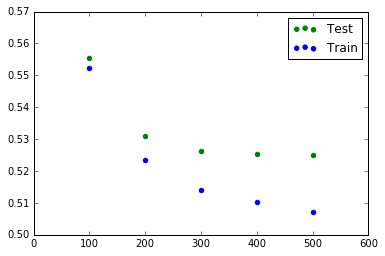

In [50]:
%matplotlib inline

from matplotlib import pyplot as plt

plt.scatter(range(100, 600, 100), test_score, color='g', label='Test')
plt.scatter(range(100, 600, 100), train_score, color='b', label='Train')
plt.legend()
plt.show()

In [45]:
test_score = []
train_score = []

for max_depth in range(2,11):
    xgb_params = {'objective': 'reg:linear', 'eta': 0.01, 'max_depth': 5, 'seed': 42, 'eval_metric': 'logloss'}
    # Format the matrices for xgb
    dtrain_imp = xgb.DMatrix(X_train_imp, label = Y_train_imp)
    dtest_imp = xgb.DMatrix(X_test_imp, label = Y_test_imp)
    gbdt_imp = xgb.train(xgb_params, dtrain_imp, 300)

    # Get the predicted values for the test data
    Y_test_pred_imp = gbdt_imp.predict(dtest_imp)
    Y_test_pred_imp[Y_test_pred_imp > 1] = 1
    Y_test_pred_imp[Y_test_pred_imp < 0] = 0

    # ... and again for the training data. Do this to check for overfitting
    Y_train_pred_imp = gbdt_imp.predict(dtrain_imp)
    Y_train_pred_imp[Y_train_pred_imp > 1] = 1
    Y_train_pred_imp[Y_train_pred_imp < 0] = 0
    
    test_score.append(logloss(Y_test_imp, Y_test_pred_imp))
    train_score.append(logloss(Y_train_imp, Y_train_pred_imp))



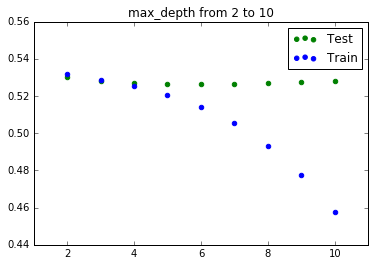

In [46]:
plt.scatter(range(2,11), test_score, color='g', label='Test')
plt.scatter(range(2,11), train_score, color='b', label='Train')
plt.legend()
plt.title('max_depth from 2 to 10')
plt.show()